In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("csc475-575-Spring2022-assignment4.ipynb")

# CSC475/575 Spring 2022 - Assignment 4

This assignment covers topics related to genre classification and collection visualizaton. Information about the course can be found at the 
[CSC475/575 Brightspace](https://bright.uvic.ca/d2l/home/196001). 


* A4.1: Genre classification   
* A4.2: Comparison of classifiers  
* A4.3: Mean and std of beats as features  
* A4.4: Scattar plots using beat features, PCA, t-SNE   
* A4.5: musicnn tags -> naive bayes classifier 

CSC575 only (instead of A4.1): 
* A4.G: visualization of tags and confusion matrix 

Each question is worth 2 points for a total of 10 points for the assignment. 


In [2]:
import numpy as np
import random
import IPython.display as ipd
import matplotlib.pyplot as plt
import math 
%matplotlib inline
import otter
grader = otter.Notebook()

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.datasets import load_svmlight_file
from sklearn import svm, metrics
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import os
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE

#### **Question A4.1 (basic):** 
 

This question is based on this file containing audio features for 3 genres (classical, jazz, and metal) from the GTZAN dataset. It is in svmlight format that scikit-learn can read (the file is provided as an attachment to the assignment). 


`3genres_full.arff.libsvm`

Read the file and perform a classification experiment using a K nearest neighbor classifier (K=3). Each file is represented by 124 audio features. You don't have to implement the classifier from scratch but can use the implementation provided by scikit-learn. Use a MinMaxScaler to normalize the features and perform 5-fold cross-validation. Show the resulting classification report and confusion matrix. Feel free to use any functionality provided by sklearn. 


 (**Basic: 2 points**)


In [3]:
data = load_svmlight_file('3genres_full.arff.libsvm')
X,Y = data[0], data[1]
X = X.toarray()
Y = Y.astype(int)
print(X.shape)

minmaxscaler = preprocessing.MinMaxScaler()
normalized_X = minmaxscaler.fit_transform(X)

clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(normalized_X, Y)

predicted_knn = cross_val_predict(clf_knn, normalized_X, Y, cv=5)

print("Confusion matrix:\n%s" % metrics.confusion_matrix(Y, predicted_knn))
print("Classification report for classifier %s:\n%s\n"
      % (clf_knn, metrics.accuracy_score(Y, predicted_knn)))

(300, 124)
Confusion matrix:
[[91  6  3]
 [ 8 84  8]
 [ 0  1 99]]
Classification report for classifier KNeighborsClassifier(n_neighbors=3):
0.9133333333333333



#### **Question A4.2 (basic):** 

Compare the following classifiers in terms of classification accuracy using 5-fold cross-validation. 

1. Linear support vector machine: SVC(kernel="linear", C=0.025)
2. RBF support vector machine:  SVC(gamma=2, C=1)
3. Decision tree: DecisionTreeClassifier(max_depth=5)
4. Gaussian Naive Bayes classifier: GaussianNB()


(**Basic: 2 points**)


In [4]:
#1. Linear support vector machine: SVC(kernel="linear", C=0.025)
clf_lsvc = svm.SVC(kernel="linear", C=0.025)
clf_lsvc.fit(normalized_X, Y)
predicted_lsvc = cross_val_predict(clf_lsvc, normalized_X, Y, cv=5)
print("Classification accuracy linear SVC: " + str(metrics.accuracy_score(Y, predicted_lsvc)))

#2. RBF support vector machine:  SVC(gamma=2, C=1)
clf_rsvc = svm.SVC(gamma=2, C=1)
clf_rsvc.fit(normalized_X, Y)
predicted_rsvc = cross_val_predict(clf_rsvc, normalized_X, Y, cv=5)
print("Classification accuracy rbf SVC: " + str(metrics.accuracy_score(Y, predicted_rsvc)))

#3. Decision tree: DecisionTreeClassifier(max_depth=5)
clf_dt = DecisionTreeClassifier(max_depth=5)
clf_dt.fit(normalized_X, Y)
predicted_dt = cross_val_predict(clf_dt, normalized_X, Y, cv=5)
print("Classification accuracy Decision trees: " + str(metrics.accuracy_score(Y, predicted_dt)))

#4. Gaussian Naive Bayes classifier: GaussianNB()
clf_nb = GaussianNB()
clf_nb.fit(normalized_X, Y)
predicted_nb = cross_val_predict(clf_nb, normalized_X, Y, cv=5)
print("Classification accuracy Naive Bayes: " + str(metrics.accuracy_score(Y, predicted_nb)))

Classification accuracy linear SVC: 0.9133333333333333
Classification accuracy rbf SVC: 0.8066666666666666
Classification accuracy Decision trees: 0.7933333333333333
Classification accuracy Naive Bayes: 0.81


**Question A4.3 (expected):** 

In this question we explore the use of an alternative feature front-end based on beat tracking. 
We will use the manually annotated beats that can be found at: 
https://github.com/TempoBeatDownbeat/gtzan_tempo_beat

This is a bit unrealistic as they are manually created but it will serve for illustration purposes. 
Selet the three genres (classical, jazz, metal) and represent each track using two features: 
the mean of the inter-beat durations (the beat period), and the standard deviation of the inter-beat durations. 

Run a classification experiment as in the previous questions using 5-fold cross-validation and classification accuracy as a metric. Compare the results obtained for the following configurations using a linear Support Vector Machine (SVM) classifier: 

1. The two beat-period features 
2. The first two features from the 124 feature vector loaded in question A4.1 
3. The two beat-period features concatenated with the first two features from the 124 feature vector 
4. The 124 feature vector 

**(2 points)** 


In [5]:
all_classical = os.listdir("./beats/classical")
all_jazz = os.listdir("./beats/jazz")
all_metal = os.listdir("./beats/metal")

mean_bp = []
stddev_bp = []

for file in all_classical:
    filename = "./beats/classical/" + str(file)
    beats1 = np.loadtxt(filename)
    beats1 = beats1[:,0]
    bp = np.zeros(len(beats1)-1)
    
    for i in range(0,len(beats1)-1):
        bp[i] = beats1[i+1] - beats1[i]
    
    mean_bp.append(np.mean(bp))
    stddev_bp.append(np.std(bp))

for file in all_jazz:
    filename = "./beats/jazz/" + str(file)
    beats2 = np.loadtxt(filename)
    try:
        beats2 = beats2[:,0]
    except:
        beats2 = beats2
    bp = np.zeros(len(beats2)-1)
    
    for i in range(0,len(beats2)-1):
        bp[i] = beats2[i+1] - beats2[i]
    
    mean_bp.append(np.mean(bp))
    stddev_bp.append(np.std(bp))

for file in all_metal:
    filename = "./beats/metal/" + str(file)
    beats3 = np.loadtxt(filename)
    beats3 = beats3[:,0]
    bp = np.zeros(len(beats3)-1)
    
    for i in range(0,len(beats3)-1):
        bp[i] = beats3[i+1] - beats3[i]
    
    mean_bp.append(np.mean(bp))
    stddev_bp.append(np.std(bp))
    
mean_bp = np.array(mean_bp)
stddev_bp = np.array(stddev_bp)

bp_feats = np.column_stack([mean_bp, stddev_bp])
minmaxscaler = preprocessing.MinMaxScaler()
normalized_bp_feats = minmaxscaler.fit_transform(bp_feats)


clf_lsvc = svm.SVC(kernel="linear", C=0.025)

#1. The two beat-period features 
clf_lsvc.fit(normalized_bp_feats, Y)
predicted1 = cross_val_predict(clf_lsvc, normalized_bp_feats, Y, cv=5)
print("Classification accuracy 1. two bp feats: " + str(metrics.accuracy_score(Y, predicted1)))

#2. The first two features from the 124 feature vector loaded in question A4.1 

new_X = normalized_X[:,:2]
clf_lsvc.fit(new_X, Y)
predicted2 = cross_val_predict(clf_lsvc, new_X, Y, cv=5)
print("Classification accuracy 2. first 2 features out of 124: " + str(metrics.accuracy_score(Y, predicted2)))

#3. The two beat-period features concatenated with the first two features from the 124 feature vector 
conc_X = np.column_stack([normalized_X, bp_feats])
clf_lsvc.fit(conc_X, Y)
predicted3 = cross_val_predict(clf_lsvc, conc_X, Y, cv=5)
print("Classification accuracy 3. concatenated bp and original feats: " + str(metrics.accuracy_score(Y, predicted3)))

#4. The 124 feature vector
clf_lsvc.fit(normalized_X, Y)
predicted4 = cross_val_predict(clf_lsvc, normalized_X, Y, cv=5)
print("Classification accuracy 4. original 124 features  : " + str(metrics.accuracy_score(Y, predicted4)))

Classification accuracy 1. two bp feats: 0.38
Classification accuracy 2. first 2 features out of 124: 0.5466666666666666
Classification accuracy 3. concatenated bp and original feats: 0.9133333333333333
Classification accuracy 4. original 124 features  : 0.9133333333333333


<!-- BEGIN QUESTION -->

#### **Question A4.4 (expected):** 

Show scatter plots of the following configurations using different colors for each genre (classical: blue, jazz:green and metal: red): 

1. The beat-period 2 features 
2. The first 2 features from the 124 feature vector 
3. The first two principal components using PCA on the 124-dimensional feature vectors 
4. A two-dimensional t-SNE plot using the 124-dimensional feature vectors 

You can adapt the following code for this question: 
https://github.com/gtzan/mir_program_kadenze/tree/master/course2/session6


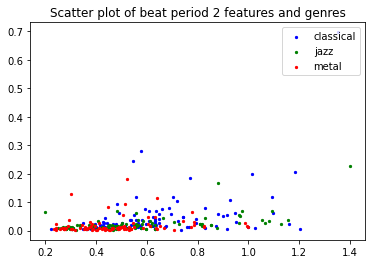

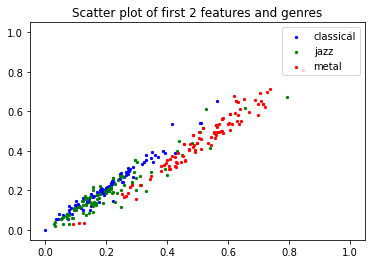

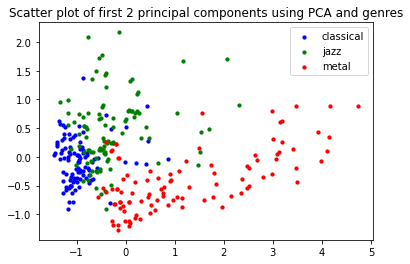

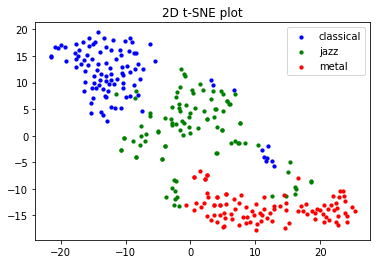

In [6]:
target_names = ['classical', 'jazz', 'metal']
colors = ['blue', 'green', 'red']

#1. The beat-period 2 features 
for n, color in enumerate(colors):
    data = bp_feats[Y==n]
    plt.scatter(data[:, 0], data[:, 1], s=5, color=color,
                    label=target_names[n])
    plt.title('Scatter plot of beat period 2 features and genres')
    plt.legend(scatterpoints=1, loc='upper right', prop=dict(size=10))
plt.show()

#2. The first 2 features from the 124 feature vector 
for n, color in enumerate(colors):
    new_X = normalized_X[:,:2]
    data = new_X[Y==n]
    plt.scatter(data[:, 0], data[:, 1], s=5, color=color,
                    label=target_names[n])
    plt.title('Scatter plot of first 2 features and genres')
    plt.legend(scatterpoints=1, loc='upper right', prop=dict(size=10))
plt.show()

#3. The first two principal components using PCA on the 124-dimensional feature vectors 
data = PCA(n_components=2).fit_transform(normalized_X)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(data[Y == i, 0], data[Y == i, 1], color=color, 
                    lw=2, label=target_name, s=5)
    plt.title('Scatter plot of first 2 principal components using PCA and genres')
    plt.legend(scatterpoints=1, loc='upper right', prop=dict(size=10))
plt.show()

#4. A two-dimensional t-SNE plot using the 124-dimensional feature vectors 
data = TSNE(n_components=2, init='pca', random_state=0).fit_transform(normalized_X)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(data[Y == i, 0], data[Y == i, 1], color=color, 
                    lw=2, label=target_name, s=5)
    plt.title('2D t-SNE plot')
    plt.legend(scatterpoints=1, loc='upper right', prop=dict(size=10))
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question A4.5 (advanced):** 

Extend the visualization from the previous question to visualize the prediction labels in addition to the ground truth labels. Use two concentric circles with the larger one being the ground truth and the smaller one being the prediction (classical: blue/turquoise, jazz: green/brown, country: red:yellow). For classification use a linear SVM for the four configurations from the previous question. Each scatter plot should have a title showing the corresponding classification using 5-fold cross-validation. 

**(2 points)**


_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### **Question A4.G (CSC575/advanced):** 

This question only needs to be answered by graduate students who are registered in CSC575 and for these students it will be graded instead of question A4.1 which is optional for them. 

For this question you will need to be able to run the `musicnn` auto-tagger developed by Jordi Pons: 
https://github.com/jordipons/musicnn

For each track in the three genres (classical, jazz, metal) we have been exploring in this question calculate the topN (N=10) tags using the `MSD_musicnn` model. Find the 15 most 'popular' tags that is the tags that appear most times in the 300 tracks we are examining. Convert each track to a binary bag of words representation using these 15 most popular tags. Now each track should be represented by 15 binary numbers. 

Adapt the code from performing classification based on lyrics shown at the bottom of this notebook to perform 
Naive Bayes classification using the tag bag-of-words representation: 

https://github.com/gtzan/csc421_tzanetakis/blob/main/csc421_tzanetakis_quantifying_uncertainty.ipynb


<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()